In [1]:
from multiprocessing import Pool
from multiprocessing import cpu_count
from anomalies import anomaly
import numpy as np
import pickle
from itertools import permutations 
from itertools import combinations_with_replacement

# Functions

In [2]:
def m_value(n):
    """
    m value for both even and odd cases
    
    Parameters
    ----------
    `n`: int, number of elements in the solution
    
    Returns
    -------
    `m`: int, number of elements in l and k lists
    """
    if n%2==0:
        m = n/2 -1
    else:
        m = (n-3)/2
    return int(m)

In [3]:
def all_comb_array(size):
    """
    A partir de un arreglo con los números [-5, -4, -3, -2, -1,  1,  2,  3,  4,  5]
    se crean arreglos de tamaño `size` que contengan todas las combinaciones posibles
    
    Parameters
    ----------
    `size`: int, tamaño de los arreglos que se quieren crear con las combinaciones de los números
            entre -5 y 5, sin considerar el cero
    
    Returns
    -------
    `final_combinations`: list, lista de tuplas de listas con todas las combinaciones de 
                        tamaño `size`
    """
    
    lista = np.arange(-5,6)
    ##Borramos el número cero de la lista
    lista_eff = np.delete(lista, 5)

    ##Creamos un arreglo con todas las combinaciones con reemplazo de tamaño dos con los objetos de lista
    ##Si yo tengo el arreglo [1,2,3] la combinación con reemplazo me da la siguiente solución
    ## A = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
    all_combinations = list(combinations_with_replacement(lista_eff, size))

    ##La permutación de las anteriores combinaciones de A dan el siguiente resultado
    ##array([[[1, 1],[1, 1]],  ----> Eliminamos luego uno de estos
    ##       [[1, 2],[2, 1]],
    ##       [[1, 3],[3, 1]],
    ##       [[2, 2],[2, 2]],  ----> Eliminamos luego uno de estos
    ##       [[2, 3],[3, 2]],
    ##       [[3, 3],[3, 3]]]) ----> Eliminamos luego uno de estos
    perm = list(map(permutations, all_combinations))
    perm_list = np.array(list(map(list, perm)))
    shape = np.shape(perm_list)
    
    ##Volvemos todas las combinaciones en un arreglo 1D
    perm_list_1D = np.reshape(perm_list, (shape[0]*shape[1], shape[2]))
    ##Eliminamos los elementos repetidos
    final_combinations = [list(x) for x in set(tuple(x) for x in perm_list_1D)]
    return final_combinations

all_comb_array(1)

[[-4], [2], [5], [-5], [-1], [-2], [4], [1], [-3], [3]]

In [4]:
def l_and_k_arrays(n):
    """
    Genera arreglos para l y k dependiendo de `n` con los cuales se van a obtener las
    soluciones quirales
    
    Parameters
    ----------
    `n`: int, number of elements in the solution
    
    Returns
    -------
    `all_combinations_lk`: list, lista de tuplas con las posibles combinaciones de l y k [(l1,k1),..]
    """
    m = m_value(n)
    
    l_dummy = all_comb_array(m)
    
    ##Para el caso impar: l y k tienen dimensiones diferentes, los combinamos diferente :P
    if n %2 != 0:
        k_dummy = all_comb_array(m+1)
        #print(len(l_dummy), len(k_dummy))
        
        all_combinations_lk = [(i,j)for i in l_dummy for j in k_dummy]
    
    ##En el caso par: l y k tienen las mismas dimensiones
    else:
        all_combinations_lk = list(combinations_with_replacement(l_dummy, 2))
            
    return all_combinations_lk

x=l_and_k_arrays(5)

In [5]:
def is_vectorlike_solution(solution):
    """
    Verifica si al menos existe un elemento con su opuesto, si es el caso entonces es
    vectorlike y se marca como true para ser descartado
    
    Parameters
    ----------
    `solution`: list, solución a la operación merger
    
    Returns
    -------
    `isvectorlike`: bool, regresa verdadero si es una solución vectorlike
    """
    solution = np.array(solution)
    ##De la solución sacamos en valor absoluto los diferentes valores que hay
    values = np.unique(abs(solution))
    ##Asumimos de entrada que no es vectorlike
    isvectorlike = False
    
    
    for zabs in values:
        ##Si tenemos al menos una solución que contenga un cero ya decimos que es vectorlike
        if zabs == 0:
            isvectorlike = True
            break
            
        ##Miramos si para un valor está tanto su valor positivo como su negativo, si es así
        ##es vectorlike
        if - zabs in solution and zabs in solution:
            isvectorlike = True
            break
    return isvectorlike

In [6]:
def chiral_solution(n):
    """
    Soluciones quirales para `n` mayor o igual a 5
    
    Parameters
    ----------
    `n`: int, number of elements in the solution
    
    Returns
    -------
    `dict_sol`: dict, diccionario con 'key' igual al `n` cuyos valores corresponden
    a la lista de soluciones quirales.
    """
    
    sol_z = []
    vector = l_and_k_arrays(n)
    for i in vector:
        #print(i[0], i[1])
    
        anomaly.free(i[0], i[1])
        solution = anomaly.free.simplified
        ##Verificamos que sea una solución quiral y la guardamos
        if is_vectorlike_solution(solution) == False:
            sol_z += [solution]
    ##Quitamos las soluciones quirales repetidas
    sol_filtered = [list(x) for x in set(tuple(x) for x in sol_z)]
    dict_sol = {f'{n}': sol_filtered}
    
    return dict_sol

# Multiprocessing

In [7]:
n = int(input("¿Hasta que valor de n quiere calcular las soluciones quirales? mejor no se pase de 8"))
results = 0
processes = cpu_count() ##Para saber cuántos procesadores tengo 
use = 7  ##Tengo 8, entonces usaré 7
print(f"I have {processes} cores here. Using: {use}")
pool = Pool(processes=use)
results = pool.map(chiral_solution, np.arange(5,n+1)) ##Calculando los z quirales 
pool.close()
pool.join()

¿Hasta que valor de n quiere calcular las soluciones quirales? mejor no se pase de 8 8


I have 8 cores here. Using: 7


/home/lina/anaconda3/lib/python3.9/site-packages/anomalies/anomaly.py:49: RuntimeWarning: invalid value encountered in true_divide
  self.simplified=(zz/self.gcd).astype(int)
/home/lina/anaconda3/lib/python3.9/site-packages/anomalies/anomaly.py:49: RuntimeWarning: invalid value encountered in true_divide
  self.simplified=(zz/self.gcd).astype(int)
/home/lina/anaconda3/lib/python3.9/site-packages/anomalies/anomaly.py:49: RuntimeWarning: invalid value encountered in true_divide
  self.simplified=(zz/self.gcd).astype(int)


In [8]:
print(f'Las soluciones se han calculado para {len(results)} valores diferentes de n. El valor máximo es n = {n}')

Las soluciones se han calculado para 4 valores diferentes de n. El valor máximo es n = 8


In [8]:
for x in results:
    key = list(x.keys())[0]
    print(f'n: {key}, soluciones: {len(x[key])}')

n: 5, soluciones: 136
n: 6, soluciones: 1537
n: 7, soluciones: 21472
n: 8, soluciones: 111669


# Los siguientes son los números de soluciones que estaba logrando obtener cuando estaba generando $l$ y $k$ de forma aleatoria. Vemos que lograba llegar a un $n$ muy alto, pero estaba perdiendo muchas soluciones, incluso en $n=6$.

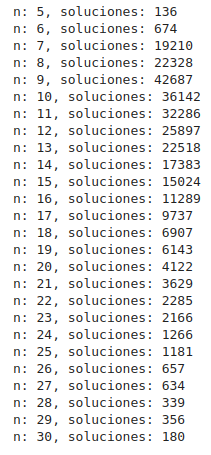

# Guardar los resultados

In [9]:
with open(f"Resultados_quirales_n8_comb", "wb") as fp:   #Pickling   
    pickle.dump(results, fp)

# Abrir los datos guardados

In [10]:
with open("Resultados_quirales_n8_comb", "rb") as fp:   # Unpickling
    sol_loaded = pickle.load(fp)

In [11]:
def eq_satisfied(x):
    """
    This function verifies that equations (z1³+z2³+ ... + zn³ = 0) and (z1+z2+ ... + zn = 0) are 
    satisfied at the same time, and if it is true, then return the input parameters
    
    Parameters
    ----------
    `x`: it correspond to the solutions z1, z2, ..., zn

    Return
    ------
    `eq_3`: int, returns the result of evaluating the equations
    `eq_1`: int, returns the result of evaluating the equations
    """
    x = np.array(x)
    eq_3 = np.sum(x**3)
    eq_1 = np.sum(x)

    return eq_3, eq_1
    
for i in sol_loaded[3]['8']:
    eq3, eq1 = eq_satisfied(i)
    assert (eq3 ==0 and eq1 ==0)

# Veamos si todas las soluciones obtenidas hasta $n=8$ son soluciones realmente

In [12]:
for i in sol_loaded:
    for enes in i.keys():
        for sols in i[enes]:
            eq3, eq1 = eq_satisfied(sols)
            assert (eq3 ==0 and eq1 ==0)

In [13]:
print(len(sol_loaded))
sol_loaded

4


[{'5': [[17, 46, -80, -81, 98],
   [-19, -23, 49, 65, -72],
   [-2, -4, 7, 9, -10],
   [-7, -9, 20, 22, -26],
   [-10, -11, 27, 28, -34],
   [-11, -19, 32, 63, -65],
   [8, 14, -23, -54, 55],
   [-40, -55, 117, 133, -155],
   [2, 159, -164, -207, 210],
   [-7, -13, 25, 27, -32],
   [55, 61, -145, -160, 189],
   [-5, -8, 14, 26, -27],
   [22, 62, -100, -117, 133],
   [5, 11, -18, -26, 28],
   [-4, -13, 18, 34, -35],
   [4, 38, -43, -90, 91],
   [13, 20, -34, -98, 99],
   [-9, -26, 42, 48, -55],
   [-4, -9, 14, 25, -26],
   [7, 30, -39, -72, 74],
   [2, 18, -23, -25, 28],
   [1, 27, -31, -32, 35],
   [-2, -18, 23, 25, -28],
   [5, 8, -14, -26, 27],
   [-7, -26, 36, 55, -58],
   [-3, -32, 39, 45, -49],
   [9, 11, -23, -32, 35],
   [17, 22, -50, -52, 63],
   [-19, -29, 50, 124, -126],
   [3, 19, -24, -33, 35],
   [-55, -61, 145, 160, -189],
   [-26, -29, 68, 77, -90],
   [-1, -63, 66, 78, -80],
   [7, 19, -27, -64, 65],
   [6, 15, -26, -28, 33],
   [-2, -19, 22, 35, -36],
   [-1, -14, 17, 